In [43]:
# Scikit-Learn
import sklearn

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

# Common imports
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Part 1: Introduction

According to the UCI: "The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load."

The data contains the below attributes on an hourly basis:
- Temperature (T): 1.81°C - 37.11°C,
- Ambient Pressure (AP): 992.89-1033.30 milibar,
- Relative Humidity (RH): 25.56% - 100.16%
- Exhaust Vacuum (V): 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW


In [6]:
data = pd.read_csv(r'/Users/alejandrazapatasoveranez/Documents/GitHub/DAV6150/datasets/M2_Data.csv')    
data.head(10)

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


# Part 2: Exploratory Data Analysis

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   EP      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [9]:
data.describe()

,T,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


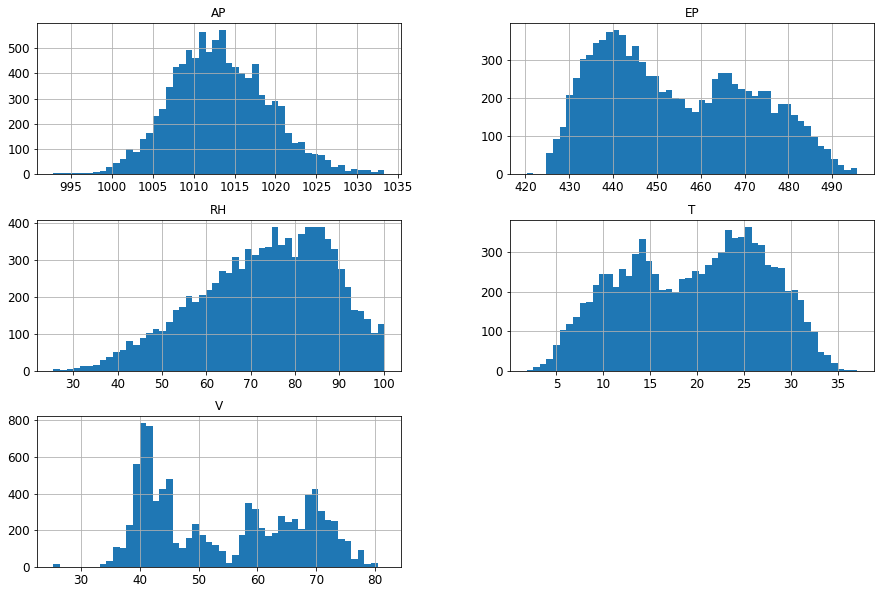

In [11]:
#use matplotlib hist to plot the histogram for all numerical variables
data.hist(bins=50, figsize=(15,10))
plt.show()

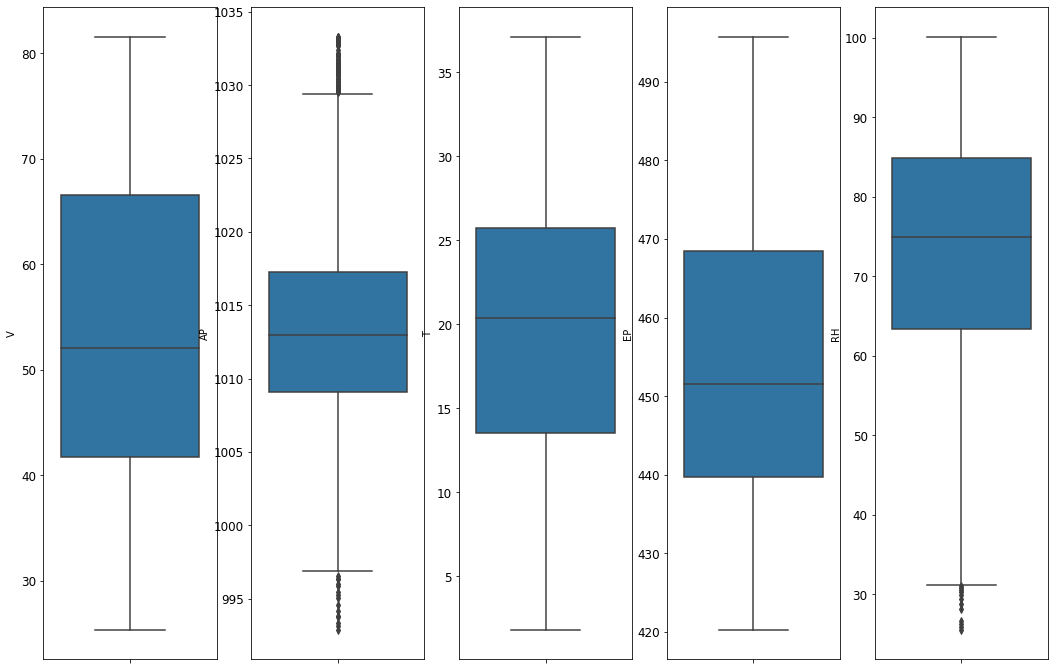

In [34]:
import seaborn as sns
#use subplots to show the boxplots for all numerical variables
fig, axes = plt.subplots(1, 5,figsize=(18,12))
sns.boxplot(ax=axes[0], x = 'V', data = data,orient='v')
sns.boxplot(ax=axes[1], x = 'AP', data = data,orient='v')
sns.boxplot(ax=axes[2], x = 'T', data = data,orient='v')
sns.boxplot(ax=axes[3], x = 'EP', data = data,orient='v')
sns.boxplot(ax=axes[4], x = 'RH', data = data,orient='v')


#### All five attributes are numerical values and don't have any nulls.
##### - For temperature(T) the mean is 19.66 C and the standard deviation is 7.45 C.
Temperature has a bimodal distribution, with one of the peaks higher than the other. The major peak is around and  the smaller one around 15. Both peaks are closer to the mean than one standard deviation. A bimodal distribution shows that we have two main groups in our data. 
##### - For exhaust vacuum(V) the mean is 54.30 cm Hg and the standard deviation is 12.70 cm Hg.
The exhaust vacuum has a multimodal distribution which indicates it is nor normally distributed. This indicates that the variable may have different patterns. There are also less data points between the mean and the lower quartile and no evident outliers.
##### - For ambient pressure(AP) the mean is 1013.25 milibar and the standard deviation is 5.9 milibar.
Ambient Pressure seems to be close to normal distribution.
##### - For relative humidity (RH) the mean is 73.30% and the standard deviation is 14.60%.
Exhaust Vacuum value is left skewed. Although the boxplot does not show there are many outliers the mean is skewed. The boxplot shows outliers which makes sense with the distribution on the histogram.
##### - For Net hourly electrical energy output (EP) the mean is 454.35 MW and the standard deviation is 17.06 MW.
The hourly energy output is also bimodal. There is also a predominant group around 440 which is less than 1 standard deviation from the mean. On the second group, the node is about 465 MW which is also less than 1 standard deviation from the mean. The boxplot does not show many outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25379890>,
      dtype=object)

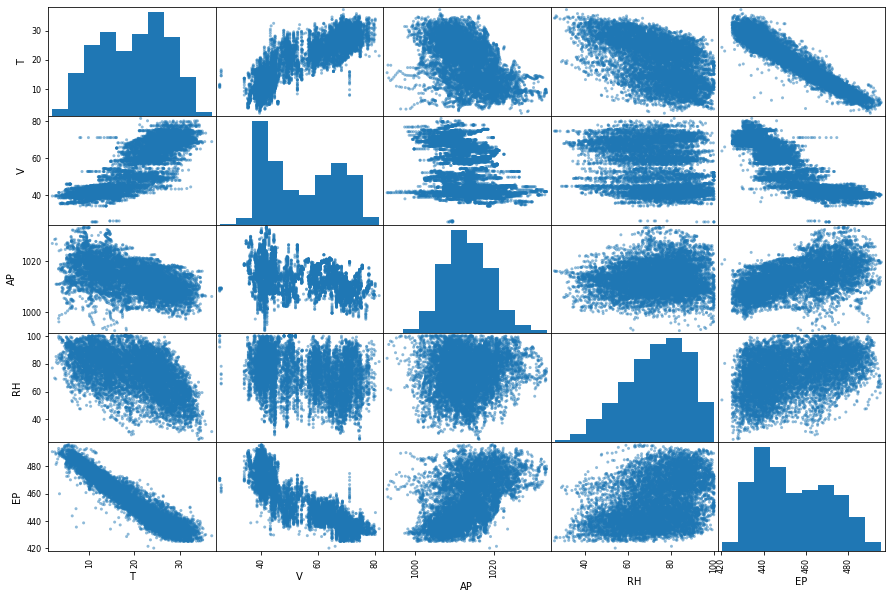

In [42]:
# scatter matrix for all variables
from pandas.plotting import scatter_matrix

attributes = ["T", "V", "AP",
              "RH", "EP"]
scatter_matrix(data[attributes], figsize=(15, 10))

The scatter matrix shows there may be some relationship between Temperature and EP, Exhaust Vacuum and EP, and Temperature with Exhaust Vacuum. However we will use a regression plot to understand the correlation from a visualization perspective better.

The matrix shows that the explanatory variables don't seem to have strong relationships so for this exercise we will focus on the correlations with the response variable.

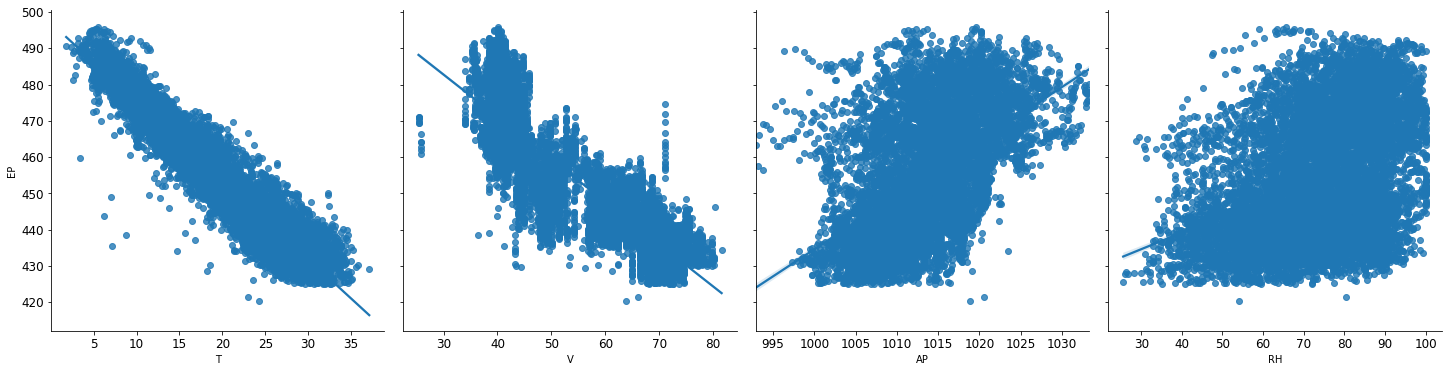

In [38]:
#regression for all variables in relationship to the net hourly electrical energy output
sns.pairplot(data=data,kind="reg",diag_kind=None,
                  x_vars= data.columns[:4],
                  y_vars=['EP'], height=5)

Both Temperature and Exhaust Vacuum variables seem to have a negative correlation to the Energy Ouput but as we evaluate our model we will define the strength of the correlation.

# Part 2: Cross-validation

From the information of the dataset we know the response variable to be the Energy Output. We will use the cross validation amongst two variables of the dataset to find those that have a higher score on the model and would be better to predict the response variable.

We know that the data set has less than 10 000 observations so to keep the sample sizes large enough we will use a 5-fold rather than a 10-fold. 

In [48]:
#separate response variable
y= data.EP
y.head()

0    463.26
1    444.37
2    488.56
3    446.48
4    473.90
Name: EP, dtype: float64

In [49]:
#copy original data frame to drop response variable
x = data.copy()
x.drop('EP',axis=1,inplace=True)
x.head()

,T,V,AP,RH
0,14.96,41.76,1024.07,73.17
1,25.18,62.96,1020.04,59.08
2,5.11,39.40,1012.16,92.14
3,20.86,57.32,1010.24,76.64
4,10.82,37.50,1009.23,96.62


In [50]:
#use train_test_split to separate the data into test and train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

In [51]:
#test data set
X_test.head()

,T,V,AP,RH
4834,28.66,77.95,1009.56,69.07
1768,17.48,49.39,1021.51,84.53
2819,14.86,43.14,1019.21,99.14
7779,22.46,58.33,1013.21,68.68
7065,18.38,55.28,1020.22,68.33


In [52]:
#train data set
X_train.head()

,T,V,AP,RH
689,31.06,67.17,1007.62,65.54
3434,7.52,41.66,1015.20,78.41
5385,20.56,64.45,1012.24,53.09
3266,29.71,73.18,1012.35,63.06
8200,9.94,41.44,1015.21,87.02


### Prediction 1

For the first prediction we will use Temperature (T) and Exhaust Vacuum (V). From our EDA, those two variables had a stronger correlation on the linear regression visualization so we will use the hypothesis that these two variables will be the best to predict the response variable.

In [53]:
# load the LinearRegression function from sklearn
from sklearn.linear_model import LinearRegression

# load the cross_val_score function from sklearn
from sklearn.model_selection import cross_val_score

# new dataframe containing only T and V
newX_train = X_train[['T', 'V']].copy()

newX_train.head()

,T,V
689,31.06,67.17
3434,7.52,41.66
5385,20.56,64.45
3266,29.71,73.18
8200,9.94,41.44


In [62]:
model = LinearRegression()

#separate train dataset into 5- fold
scores = cross_val_score(model, newX_train, y_train, cv=5)

# metrics from K-fold cross validation process
scores

array([0.91277507, 0.91435269, 0.91318309, 0.9150227 , 0.91063246])

In [55]:
# average accuracy using 5-fold
np.mean(scores)

0.9131932015682309

The mean of scores is 0.9131. This is a good score so we proof that using this two variables we could make an accurate prediction. 

### Prediction 2

To measure if our model on "Prediction 1" is the most accurate we will now use the Ambient Pressure (AP) and Relative Humidity (RH) to compare.

In [56]:
# new dataframe containing only AP and RH
newX_train_2 = X_train[['AP', 'RH']].copy()

newX_train_2.head()

,AP,RH
689,1007.62,65.54
3434,1015.20,78.41
5385,1012.24,53.09
3266,1012.35,63.06
8200,1015.21,87.02


In [57]:
model_2 = LinearRegression()

#use 5-fold again
scores_2 = cross_val_score(model_2, newX_train_2, y_train, cv=5)

#scores
print (scores_2)

[0.38612982 0.33423973 0.39980965 0.37958911 0.41286003]


In [58]:
# mean of scores
np.mean(scores_2)

0.3825256664243149

# Conclusion

From our two predictions we were able to find two variables with a high score that proof they would be a good model to predict the response variable using cross validation and linear regression model.

Furthermore we could test other variables that had correlation amongst them such as temperature (T) and Relative Humidity (RH) but for know we have tested the ones that showed correlation to the response variable.

We could also test how significant the difference is if we use a 10-fold instead of a 5-fold. 

Temperature and Exhaust Vacuum where the best two variables between these two predictions to predict the Net hourly electrical energy output with a score of 0.9131. The use of Relative Humidity (RH) and Ambient Pressure (AP) had a significantly lower score of 0.38 making our "Prediction 1" the first of these two models.

# References

1. https://scikit-learn.org/stable/modules/cross_validation.html
2. https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
3. https://seaborn.pydata.org/generated/seaborn.pairplot.html
4. https://stackabuse.com/seaborn-box-plot-tutorial-and-examples/